In [6]:
import scipy.ndimage.measurements as me
def get_orientations(ms):
    o = np.zeros(len(ms), dtype=np.int32) # orientations
    for i, m in enumerate(ms):
        m = m[:,:,0]
        y,x = me.center_of_mass(m)
        if np.isnan(x) or np.isnan(y): 
            continue
        # center coordinates
        y -= 15.5
        x -= 15.5
        # fill o with optimal orientation for each mask, to maximize exposure
        # of known information (1s in the mask) to PixelCNN
        if y>=0 and x>=0:
            if y>x:
                o[i] = 2 # 2 rotations
            elif y<=x:
                o[i] = 7 # flip + 3 rotations
        elif y>=0 and x<0:
            if y>=-x:
                o[i] = 6 # flip + 2 rotations
            elif y<-x:
                o[i] = 3 # 3 rotations
        elif y<0 and x<0:
            if y>=x:
                o[i] = 5 # flip + 1 rotations
            elif y<x:
                o[i] = 0 # no flips or rotations, this is optimal
        elif y<0 and x>=0:
            if y>=-x:
                o[i] = 1 # one rotation
            if y<-x:
                o[i] = 4 # just flip no rotation needed
    return o

def flip_rotate(x, y):
    '''
    flips and/or rotates a single image according to label y
    y is encoded to represent flips and rotations
    y \in {0..7} or y \in {-7..-1} for reversing rotations\flips
    flip indicator = y // 4 ( or y <= -4 in the negative case )
    rotation angle = (y % 4) * 90 degrees
    because of dihedral group D4 structure, in some cases the order of flip/rotation
    matters, and is dealt with accordingly.
    '''
    if y // 4 == 1 or y == -4 or y == -6:
        x = np.flip(x, len(x.shape)-2)
    if len(x.shape) == 4:
        x = np.rot90(x, k= y % 4, axes=(1,2))
    else:
        x = np.rot90(x, k= y % 4)
    if y == -5 or y == -7:
        x = np.flip(x, len(x.shape)-2)
    return x

In [14]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
with open('/home/lioruzan/latest_checkpoints2/results_0_full.pkl', 'rb') as f:
    d = pkl.load(f)

In [16]:
samp = np.zeros((0,32,32,1),dtype=np.float32)
data = samp.copy()
mask = samp.copy().astype(np.int32)
colr = np.zeros((0,32,32,3),dtype=np.float32)
prob = np.zeros(len(data), dtype=np.float32)
for i in range(1):
    if i==6: continue
    gen_data = d['gen_data']
    cutoff = d['size']
    total = len(gen_data) * len(gen_data[0][0])
    e = total-cutoff
    c = 1
    for sample_x, x, m, sample_prob, colored_x in gen_data:
        if c == len(gen_data):
            sample_x = sample_x[:-e]
            x = x[:-e]
            m = m[:-e]
            colored_x = colored_x[:-e]
            sample_prob[0] = sample_prob[0][:-e]
        samp = np.vstack([samp, sample_x])
        data = np.vstack([data, x])
        mask = np.vstack([mask, m])
        colr = np.vstack([colr, colored_x])
        prob = np.concatenate([prob, sample_prob[0]])
        c += 1

147


In [17]:
samp.min(),samp.max()

(-1.0, 1.0)

In [7]:
y=get_orientations(mask)

In [11]:
import os
os.mkdir('/home/lioruzan/Desktop/pixelcnn_examples/generated_baseline_samples')

In [21]:
c = np.zeros((0,32,32,3),dtype=np.float32)
g = np.zeros((0,32,32,1),dtype=np.float32)
x = np.zeros((0,32,32,1),dtype=np.float32)
m = np.zeros((0,32,32,1),dtype=np.int32)

for i in range(8):
    c=np.concatenate([c,colr[y==i]])
    g=np.concatenate([g,samp[y==i]])
    x=np.concatenate([x,data[y==i]])
    m=np.concatenate([m,mask[y==i]])
    

y=get_orientations(m)
for i in range(len(m)):
    cc = np.uint8(c[i]*127.5+127.5)
    gg = np.uint8(g[i]*127.5+127.5).repeat(3,2)
    xx = (x[i]).repeat(3,2).astype(np.uint8)
    mm = 255*m[i].repeat(3,2).astype(np.uint8)
    plt.axis('off')
    plt.imsave('/home/lioruzan/Desktop/pixelcnn_examples/generated_baseline_samples/{:03}_{}_c.png'.format(i+1,y[i]),np.squeeze(cc))
    plt.imsave('/home/lioruzan/Desktop/pixelcnn_examples/generated_baseline_samples/{:03}_{}_g.png'.format(i+1,y[i]),np.squeeze(gg))
    plt.imsave('/home/lioruzan/Desktop/pixelcnn_examples/generated_baseline_samples/{:03}_{}_x.png'.format(i+1,y[i]),np.squeeze(xx))
    plt.imsave('/home/lioruzan/Desktop/pixelcnn_examples/generated_baseline_samples/{:03}_{}_m.png'.format(i+1,y[i]),np.squeeze(mm))

In [9]:
xx.shape

(147, 32, 32, 3)

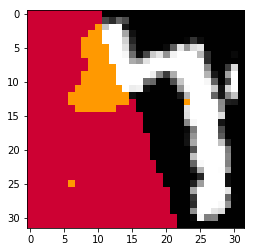

20


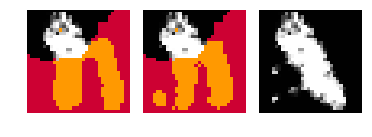

21


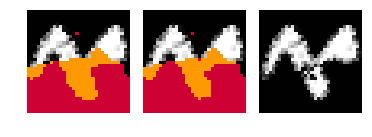

22


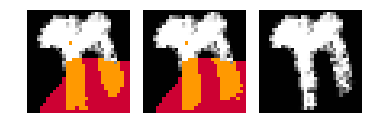

23


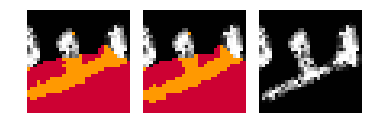

24


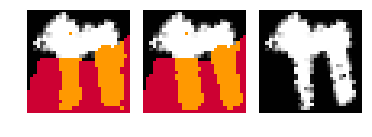

25


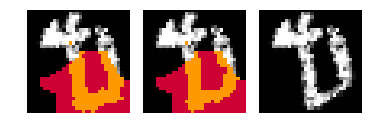

26


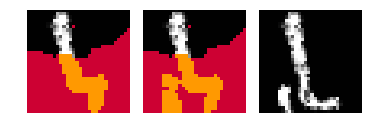

27


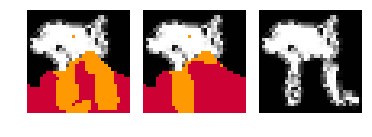

28


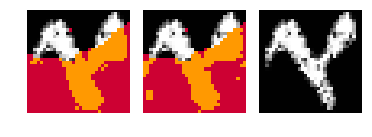

29


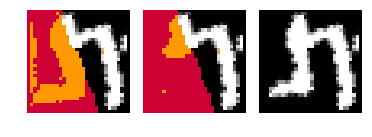

30


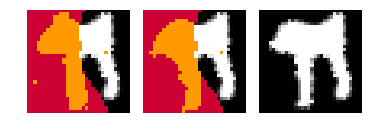

31


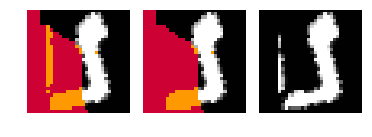

32


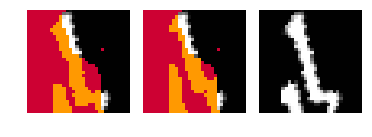

33


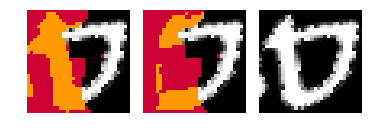

34


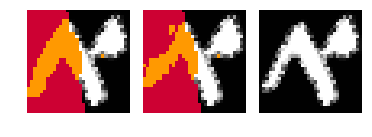

35


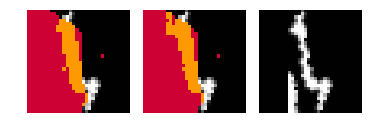

36


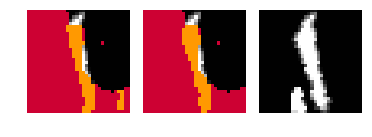

37


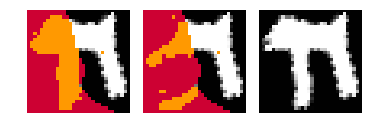

38


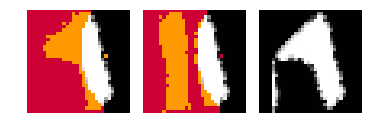

In [324]:
for im in colr:
    plt.imshow(im)
    plt.show()
    break
    


sep = np.zeros((32,4,3),dtype=np.float32)
sep.fill(1)
cc=1
for i in range(20,len(colrs[0])):
    if cc == 20:
        break
    x = (datas[0][i].repeat(3,2)-127.5)/127.5
    im = np.concatenate([colrs[0][i],sep,xx[i],sep,x],axis=1)
    print(i)
    plt.axis('off')
    plt.imshow(np.squeeze(im))
    plt.imsave('%d.png'%i,im)
    plt.show()
    cc+=1

In [1]:
import pickle as pkl
import numpy as np
import os

root = '/home/lioruzan/latest_checkpoints2'
runs = [[] for j in range(8)]
for i in range(8):
    if i==6: continue # nothing 
    r = os.path.join(root,'dir%d'%i)
    for j in range(10):
        p = os.path.join(r,'results_{}.pkl'.format(j))
        with open(p,'rb') as f:
            runs[i].append(pkl.load(f))

# format of pickled files: {'gen_data': ( sample_x, x, m, sample_prob, colored_x ), 'size': size}
samps = []
datas = []
masks = []
colrs = []
probs = []
# collect generates samples from all 8 models for each experiment (20 total)
for j in range(10):
    samp = np.zeros((0,32,32,1),dtype=np.float32)
    data = samp.copy()
    mask = samp.copy().astype(np.int32)
    colr = np.zeros((0,32,32,3),dtype=np.float32)
    prob = np.zeros(len(data), dtype=np.float32)
    for i in range(8):
        if i==6: continue
        gen_data = runs[i][j]['gen_data']
        cutoff = runs[i][j]['size']
        total = len(gen_data) * len(gen_data[0][0])
        e = total-cutoff
        c = 1
        for sample_x, x, m, sample_prob, colored_x in gen_data:
            if c == len(gen_data):
                sample_x = sample_x[:-e]
                x = x[:-e]
                m = m[:-e]
                colored_x = colored_x[:-e]
                sample_prob = sample_prob[:-e]
            samp = np.vstack([samp, sample_x])
            data = np.vstack([data, x])
            mask = np.vstack([mask, m])
            colr = np.vstack([colr, colored_x])
            prob = np.concatenate([prob, sample_prob])
            c += 1
    samps.append(samp)
    datas.append(data)
    masks.append(mask)
    colrs.append(colr)
    probs.append(prob)

In [294]:
average_psnrs=[]
std_psnrs=[]
for run in range(10):
    # calculate mean average psnr
    mses = []
    sample_x = samps[run]
    x = datas[run]
    # calculate per-picture psnr vectorized
    #change to 0..255
    a = np.round(127.5 * sample_x + 127.5)
    b = x
    mse = np.sum( np.power(a-b,2), axis=(1,2,3) ) / np.prod( a.shape[1:] ) # ignore batch size
    
    # discard all samples from padding
    
    psnrs = 20 * ( np.log10(255) - np.log10( np.sqrt(mse) ) )
    print(psnrs[0])
    psnr_avg, psnr_std = np.mean(psnrs), np.std(psnrs)
    print("average psnr run {}: {}, std: {}".format(run, psnr_avg, psnr_std))
    average_psnrs.append(psnr_avg)
    std_psnrs.append(psnr_std)
    
# show stats summary
if len(average_psnrs)>0:
    print("mean average psnr: {}, std over averages: {}, mean psnr std: {}, std over stds: {}".format(
            np.mean(average_psnrs), np.std(average_psnrs),
            np.mean(std_psnrs), np.std(std_psnrs)))

12.1695
average psnr run 0: 15.596709251403809, std: 5.038705348968506
10.5971
average psnr run 1: 15.593914031982422, std: 5.285538196563721
11.9617
average psnr run 2: 15.404359817504883, std: 4.544378280639648
13.3188
average psnr run 3: 15.384505271911621, std: 4.7966084480285645
11.0668
average psnr run 4: 15.444046974182129, std: 4.204976558685303
10.9473
average psnr run 5: 15.523222923278809, std: 4.610974311828613
12.4947
average psnr run 6: 15.897543907165527, std: 4.788308143615723
11.6331
average psnr run 7: 15.573860168457031, std: 4.8201375007629395
7.53525
average psnr run 8: 15.397482872009277, std: 4.409556865692139
12.9688
average psnr run 9: 15.604057312011719, std: 4.58445930480957
mean average psnr: 15.541971206665039, std over averages: 0.14544682204723358, mean psnr std: 4.708364009857178, std over stds: 0.29382649064064026


In [82]:
sum([len(o) for o in samps]) / 20 == 147

True

In [5]:
len(colrs[0])

147

In [6]:
# reorder full generation to bla bla blla the same
y = get_orientations(masks[0])

In [7]:
colrs00 = np.zeros((147,32,32,3),dtype=np.float32)
p = 0
for i in range(8):
    if i == 6: continue
    inds = (y==i).nonzero()[0]
    colrs00[p:p+len(inds)] = colrs[0][inds]
    p += len(inds)
p == 147

True

In [18]:
import matplotlib.pyplot as plt

data = datas[0].copy()
colr = colrs[0].copy()

cc=1
for i in range(len(colrs[0])):
    if cc == 147:
        break
    g = np.uint8(colrs[0][i]*127.5+127.5)
    x = datas[0][i].repeat(3,2).astype(np.uint8)
    plt.axis('off')    
    plt.imsave('/home/lioruzan/Desktop/adiel/generated_samples/{:03}_o.png'.format(cc),np.squeeze(x))
    plt.imsave('/home/lioruzan/Desktop/adiel/generated_samples/{:03}_g.png'.format(cc),np.squeeze(g))
    cc+=1

In [280]:
datas[0][0].min()#*127.5+127.5

0.0

In [ ]:

''' calculate mean average psnr (+- mean average std)'''
average_psnrs, std_psnrs = [], []
for o, data, _ in runss:
    psnrs=[]
    for i in range(o.shape[0]):
        #change to 0..255
        x = np.round(127.5 * o[i] + 127.5)
        y = data[i]
        #mse
        mse = np.sum( np.power(x-y,2) ) / np.prod( x.shape )
        #psnr
        psnr = 20 * ( np.log10(255) - np.log10(np.sqrt(mse)) )
        psnrs.append(psnr)
        
    psnr_avg, psnr_std = np.mean(psnrs), np.std(psnrs)
    average_psnrs.append(psnr_avg)
    std_psnrs.append(psnr_std)
print('{:.5} +-{:.5}'.format(np.mean(average_psnrs), np.mean(std_psnrs)))


In [169]:
''' PARSE DATA '''
import pandas as pd
import os

labels_csv = os.path.join('letters_data', 'labels.csv')
df = pd.read_csv(labels_csv, encoding='ISO-8859-8', header=None)
df = df.applymap(str.strip)

# clean data
doubles = df.applymap(lambda x: True if len(x)>1 and x.find('!') == -1 else False)[1]
X       = df.applymap(lambda x: True if x == 'X' else False)[1]

df = df[~doubles & ~X].reset_index(drop=True)

# label fix ש -> ה
df.iloc[3659][1]='ה!'

root = 'letters_data'
file_list = []
label_list = []
for _,y in df.iterrows():
    file_list.append(os.path.join(root,y[0][1:].replace('\\','/')))
    label_list.append(y[1])

l = sorted(list(set(label_list)))
label_to_idx = {}
for i,j in enumerate(l):
    label_to_idx[j] = i
label_list = [label_to_idx[s] for s in label_list]

In [197]:
''' IMAGE STATS '''
import scipy.misc as sm
import numpy as np

imgs = [sm.imread(file,mode='RGB') for file in file_list]

shapes=[o.shape for o in imgs]
print(np.median(shapes, axis=0), np.mean(shapes, axis=0), np.std(shapes, axis=0))
print(np.max(shapes,axis=0),np.min(shapes,axis=0))
print(np.argmax(shapes, axis=0), np.argmin(shapes,axis=0))

[ 192.  167.    3.] [ 208.19724556  168.49743231    3.        ] [ 47.07156859  29.70098797   0.        ]
[346 231   3] [143 111   3]
[947  86   0] [1566  952    0]


In [190]:
ars = np.array([o[1]/o[0] for o in shapes])
import scipy.stats as st
# st.mode(ars)[2]
np.histogram(ars,bins=10)

(array([ 201,  413,  549,  916, 1150,  553,  240,  206,   50,    6]),
 array([ 0.34124629,  0.46726152,  0.59327675,  0.71929198,  0.84530722,
         0.97132245,  1.09733768,  1.22335291,  1.34936814,  1.47538337,
         1.6013986 ]))

In [196]:
ars=sorted(ars)
for j in ars: print(j)

0.341246290801
0.365325077399
0.373134328358
0.374622356495
0.375404530744
0.380952380952
0.382089552239
0.383561643836
0.384146341463
0.386581469649
0.386627906977
0.387096774194
0.387573964497
0.387959866221
0.388535031847
0.389380530973
0.389380530973
0.39222614841
0.39222614841
0.394039735099
0.398119122257
0.398713826367
0.400621118012
0.403846153846
0.404761904762
0.405660377358
0.405693950178
0.405797101449
0.405882352941
0.407624633431
0.407738095238
0.408823529412
0.409395973154
0.41049382716
0.41134751773
0.411764705882
0.41265060241
0.413793103448
0.415625
0.415807560137
0.41592920354
0.416129032258
0.416666666667
0.418238993711
0.418918918919
0.419642857143
0.419672131148
0.419825072886
0.420074349442
0.42071197411
0.421538461538
0.421686746988
0.422442244224
0.422818791946
0.424242424242
0.424354243542
0.424836601307
0.425
0.425219941349
0.425605536332
0.425655976676
0.426035502959
0.427184466019
0.427272727273
0.42750929368
0.427609427609
0.428571428571
0.428571428571
0.4

In [3]:
for m in test_letters['masks']:
    sm.imshow(m*255)
    break

In [20]:
len(test_letters['masks'])

147

In [28]:
''' MAKE IMAGES '''
import scipy.misc as sm
import numpy as np

imgs = [sm.imread(file,mode='RGB') for file in file_list]

# resized_imgs = [sm.imresize(im,(32,32)) for im in imgs]

# resized_imgs = [im[np.newaxis,:,:,:] for im in resized_imgs]
# images = np.vstack(resized_imgs)
# labels = np.array(label_list)

[ 192.  167.    3.] [ 47.07156859  29.70098797   0.        ]


In [29]:
''' IMAGE STATS '''
shapes=[o.shape for o in imgs]
print(np.median(shapes, axis=0), np.mean(shapes, axis=0), np.std(shapes, axis=0))
print(np.max(shapes,axis=0),np.min(shapes,axis=0))
print(np.argmax(shapes, axis=0), np.argmin(shapes,axis=0))

[ 192.  167.    3.] [ 208.19724556  168.49743231    3.        ] [ 47.07156859  29.70098797   0.        ]


In [74]:
''' stitch together 4-model adaptive rotation results '''

root = '/home/lioruzan/pixel-cnn/data/letters_data/checkpoints'
runs= [[] for j in range(4)]
for i in range(4):
    r = os.path.join(root,str(i))
    for j in range(10):
        p = os.path.join(r,'results_{}.pkl'.format(j))
        with open(p,'rb') as f:
            runs[i].append(pkl.load(f))
            

runss=[]
for j in range(10):
    samp=np.zeros((0,32,32,3))
    data=samp.copy()
    mask=data.copy()
    for i in range(4):
        for sample,(x,m) in runs[i][j]:
            sample = np.rot90(sample, k=-i, axes=(1,2))
            x = np.rot90(x, k=-i, axes=(1,2))
            m = np.rot90(m, k=-i, axes=(1,2))
            samp = np.vstack([samp,sample])
            data = np.vstack([data,x])
            mask = np.vstack([mask,m])
    runss.append((samp,data,mask))

''' calculate mean average psnr (+- mean average std)'''
average_psnrs, std_psnrs = [], []
for o, data, _ in runss:
    psnrs=[]
    for i in range(o.shape[0]):
        #change to 0..255
        x = 127.5 * o[i] + 127.5
        y = data[i]
        #mse
        mse = np.sum( np.power(x-y,2) ) / np.prod( x.shape )
        #psnr
        psnr = 20 * ( np.log10(255) - np.log10(np.sqrt(mse)) )
        psnrs.append(psnr)
        
    psnr_avg, psnr_std = np.mean(psnrs), np.std(psnrs)
    average_psnrs.append(psnr_avg)
    std_psnrs.append(psnr_std)
print('{:.5} +-{:.5}'.format(np.mean(average_psnrs), np.mean(std_psnrs)))

''' visualize results '''
p=np.random.randint(140)
plt.imshow(runss[0][1][p]/127.5-1)
plt.show()
plt.imshow((runss[0][1][p]/127.5-1)*runss[0][2][p])
plt.show()
plt.imshow(runss[0][0][p])
plt.show()

In [166]:
psnrs

[8.0094482437804793,
 11.576742746439566,
 14.397416623109148,
 16.050003389271453,
 13.547408969241141,
 23.056076520934205,
 12.633913553358219,
 10.246024123511299,
 15.334448796610154,
 11.782192016462133,
 17.510175958815275,
 14.843173007889474,
 16.122954277595923,
 9.2200377348149019,
 11.28626104247334,
 13.515986057497367,
 12.148469563477926,
 9.8219308970910735,
 8.7616479031172201,
 9.9355380158090778,
 19.154202360878038,
 9.3201170342204023,
 16.84945659447223,
 8.0179964062435083,
 45.277232672125834,
 16.739734812845398,
 17.787932509869016,
 14.943535805970427,
 17.171969258429161,
 16.404846435637506,
 9.6479973378444903,
 18.378914848942021,
 15.494049563983769,
 10.581258431914232,
 10.126872069824966,
 16.304898685291889,
 10.819779646181988,
 14.685991622401652,
 15.172440514593362,
 12.363724994144203,
 18.359321153140389,
 20.18213067097788,
 14.180420893095897,
 8.9782805376706776,
 16.63958832636947,
 12.905960815126329,
 13.885445578248623,
 9.83530878940037

In [3]:
import scipy.ndimage.measurements as me
def get_orientations(ms):
    o = np.zeros(len(ms), dtype=np.int32) # orientations
    for i, m in enumerate(ms):
        m = m[:,:,0]
        y,x = me.center_of_mass(m)
        if np.isnan(x) or np.isnan(y): 
            continue
        # center coordinates
        y -= 15.5
        x -= 15.5
        # fill o with optimal orientation for each mask, to maximize exposure
        # of known information (1s in the mask) to PixelCNN
        if y>=0 and x>=0:
            if y>x:
                o[i] = 2 # 2 rotations
            elif y<=x:
                o[i] = 7 # flip + 3 rotations
        elif y>=0 and x<0:
            if y>=-x:
                o[i] = 6 # flip + 2 rotations
            elif y<-x:
                o[i] = 3 # 3 rotations
        elif y<0 and x<0:
            if y>=x:
                o[i] = 5 # flip + 1 rotations
            elif y<x:
                o[i] = 0 # no flips or rotations, this is optimal
        elif y<0 and x>=0:
            if y>=-x:
                o[i] = 1 # one rotation
            if y<-x:
                o[i] = 4 # just flip no rotation needed
    return o

def flip_rotate(x, y):
    '''
    flips and/or rotates a single image according to label y
    y is encoded to represent flips and rotations
    y \in {0..7} or y \in {-7..-1} for reversing rotations\flips
    flip indicator = y // 4 ( or y <= -4 in the negative case )
    rotation angle = (y % 4) * 90 degrees
    because of dihedral group D4 structure, in some cases the order of flip/rotation
    matters, and is dealt with accordingly.
    '''
    if y // 4 == 1 or y == -4 or y == -6:
        x = np.flip(x, len(x.shape)-2)
    if len(x.shape) == 4:
        x = np.rot90(x, k= y % 4, axes=(1,2))
    else:
        x = np.rot90(x, k= y % 4)
    if y == -5 or y == -7:
        x = np.flip(x, len(x.shape)-2)
    return x

In [130]:
import pickle as pkl
with open('./letters_data/letters_test.pkl', 'rb') as f:
    q=pkl.load(f)

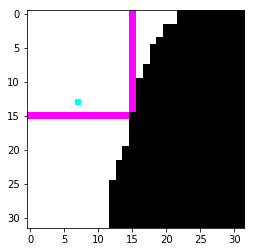

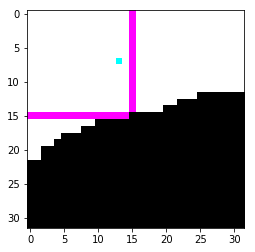

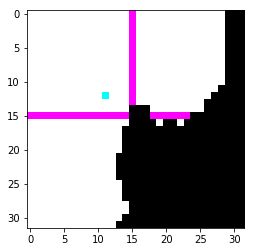

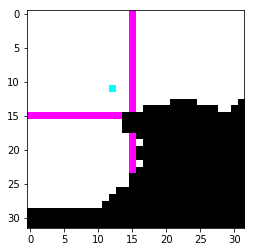

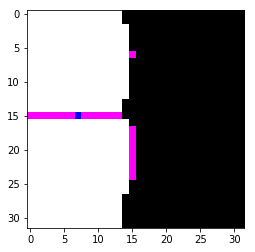

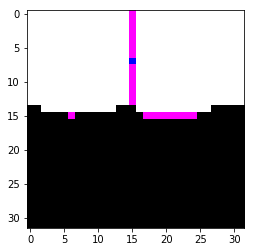

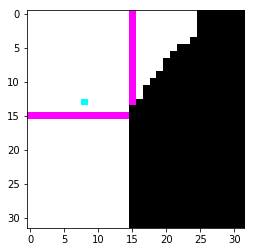

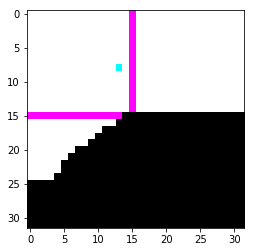

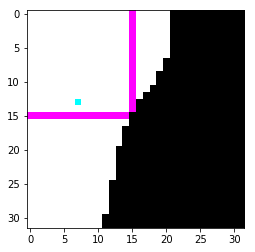

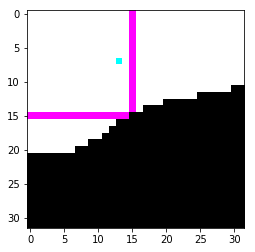

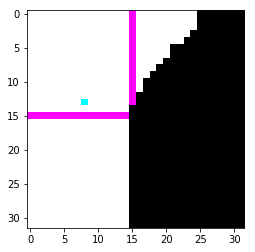

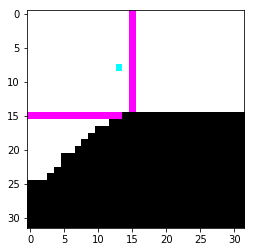

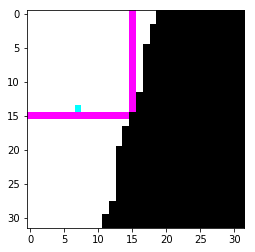

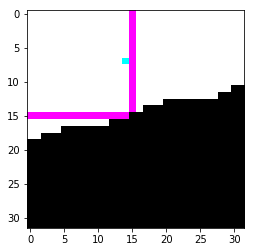

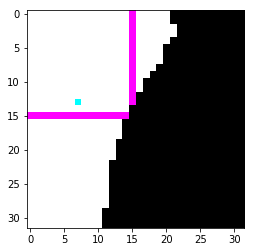

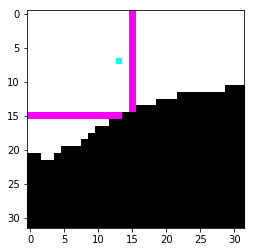

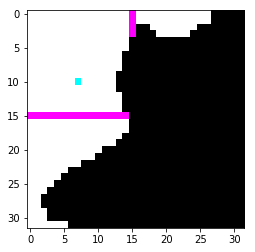

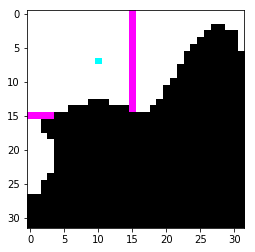

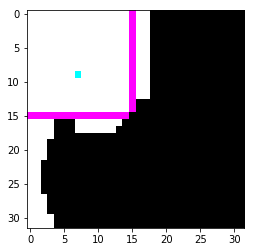

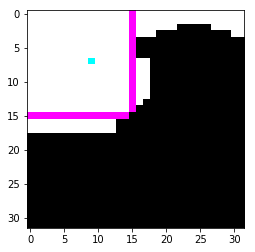

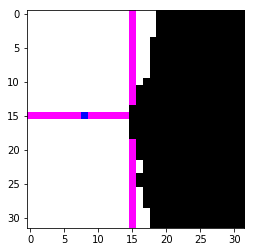

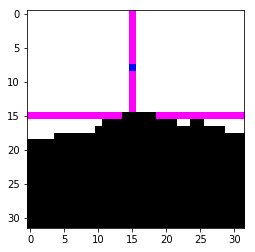

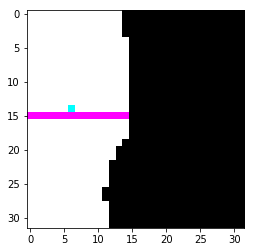

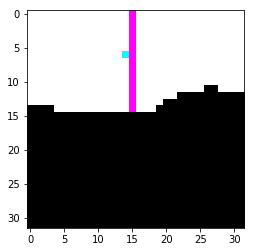

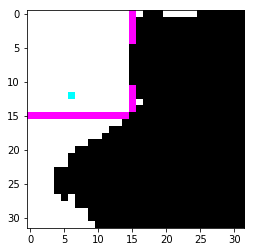

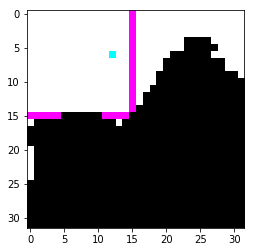

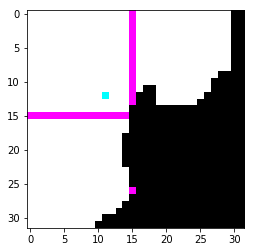

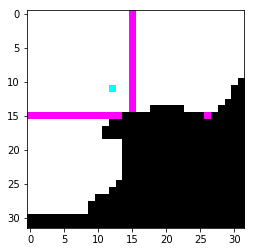

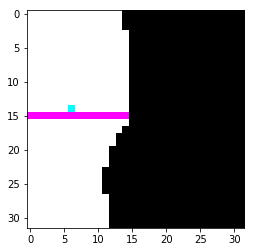

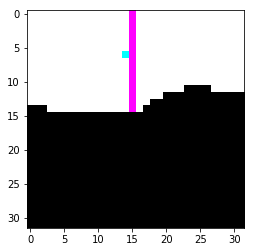

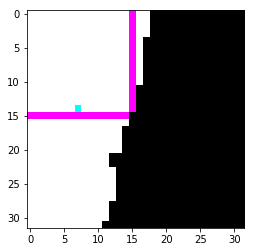

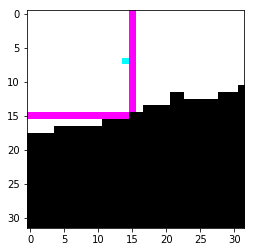

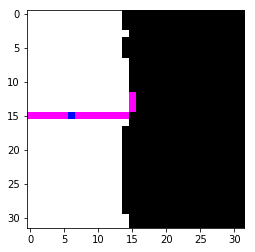

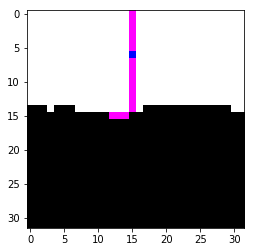

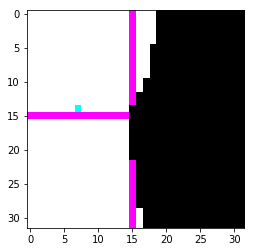

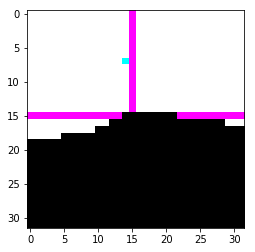

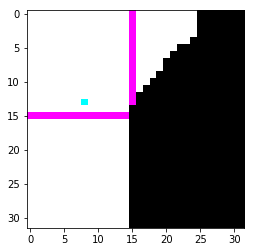

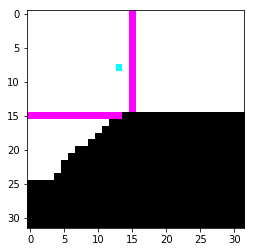

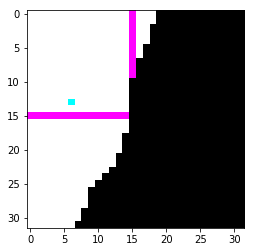

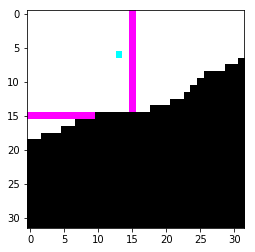

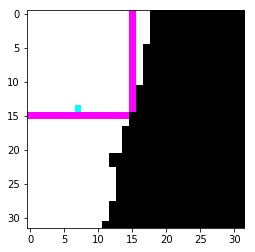

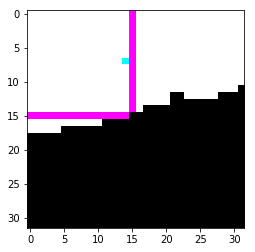

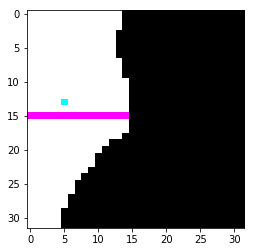

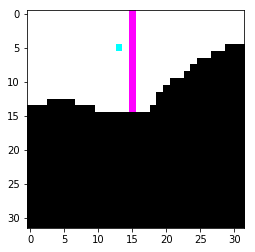

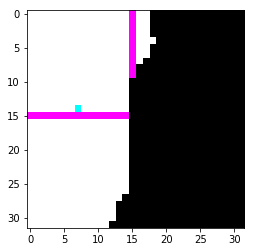

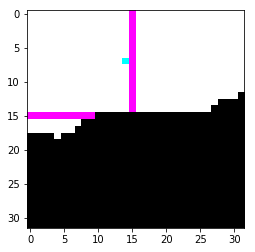

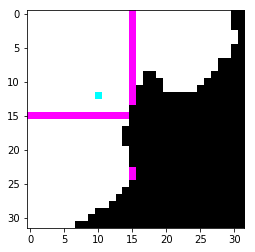

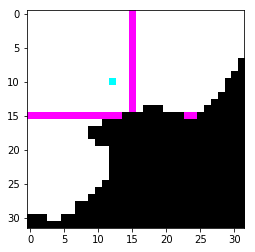

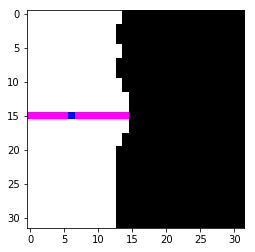

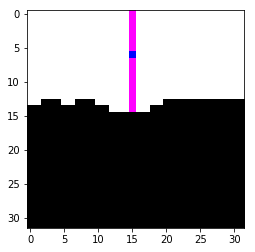

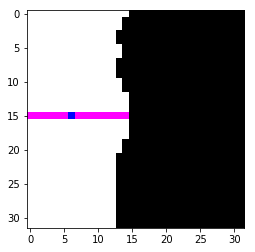

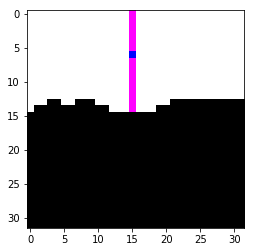

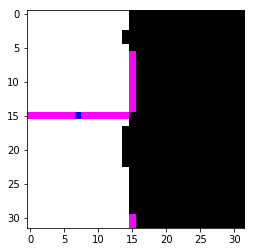

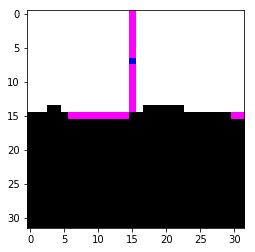

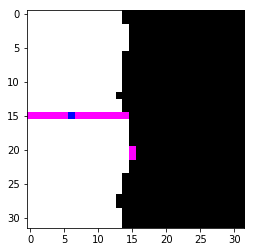

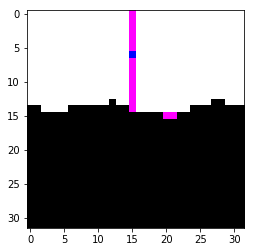

In [187]:
ms = q['masks']

y = get_orientations(ms)



for j in (y==5).nonzero()[0]:
    
    m=ms[j]*255
    mf=flip_rotate(ms[j],y[j])*255

    ym,xm = me.center_of_mass(m[...,0])
    ym,xm=int(ym),int(xm)
    m[ym,xm,0]=0
    m[:,15,1]=0
    m[15,:,1]=0
    ymf,xmf = me.center_of_mass(mf[...,0])
    ymf,xmf=int(ymf),int(xmf)
    mf[ymf,xmf,0]=0
    mf[:,15,1]=0
    mf[15,:,1]=0
    plt.imshow(m)
    plt.show()
    plt.imshow(mf)
    plt.show()

# SEPARATOR

In [1]:
'''
Copied from OpenAI's pixel_cnn_pp/plotting.py
'''

import numpy as np
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt

# Plot image examples.
def plot_img(img, title=None):
    plt.figure()
    plt.imshow(img, interpolation='nearest')
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show(block=False)

def img_stretch(img):
    img = img.astype(float)
    img -= np.min(img)
    img /= np.max(img)+1e-12
    return img

def img_tile(imgs, aspect_ratio=1.0, tile_shape=None, border=1,
             border_color=0, stretch=False):
    ''' Tile images in a grid.
    If tile_shape is provided only as many images as specified in tile_shape
    will be included in the output.
    '''

    # Prepare images
    if stretch:
        imgs = img_stretch(imgs)
    imgs = np.array(imgs)
    if imgs.ndim != 3 and imgs.ndim != 4:
        raise ValueError('imgs has wrong number of dimensions.')
    n_imgs = imgs.shape[0]

    # Grid shape
    img_shape = np.array(imgs.shape[1:3])
    if tile_shape is None:
        img_aspect_ratio = img_shape[1] / float(img_shape[0])
        aspect_ratio *= img_aspect_ratio
        tile_height = int(np.ceil(np.sqrt(n_imgs * aspect_ratio)))
        tile_width = int(np.ceil(np.sqrt(n_imgs / aspect_ratio)))
        grid_shape = np.array((tile_height, tile_width))
    else:
        assert len(tile_shape) == 2
        grid_shape = np.array(tile_shape)

    # Tile image shape
    tile_img_shape = np.array(imgs.shape[1:])
    tile_img_shape[:2] = (img_shape[:2] + border) * grid_shape[:2] - border

    # Assemble tile image
    tile_img = np.empty(tile_img_shape)
    tile_img[:] = border_color
    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            img_idx = j + i*grid_shape[1]
            if img_idx >= n_imgs:
                # No more images - stop filling out the grid.
                break
            img = imgs[img_idx]
            yoff = (img_shape[0] + border) * i
            xoff = (img_shape[1] + border) * j
            tile_img[yoff:yoff+img_shape[0], xoff:xoff+img_shape[1], ...] = img

    return tile_img.astype(np.uint8)

def conv_filter_tile(filters):
    n_filters, n_channels, height, width = filters.shape
    tile_shape = None
    if n_channels == 3:
        # Interpret 3 color channels as RGB
        filters = np.transpose(filters, (0, 2, 3, 1))
    else:
        # Organize tile such that each row corresponds to a filter and the
        # columns are the filter channels
        tile_shape = (n_channels, n_filters)
        filters = np.transpose(filters, (1, 0, 2, 3))
        filters = np.resize(filters, (n_filters*n_channels, height, width))
    filters = img_stretch(filters)
    return img_tile(filters, tile_shape=tile_shape)
    
def scale_to_unit_interval(ndar, eps=1e-8):
  """ Scales all values in the ndarray ndar to be between 0 and 1 """
  ndar = ndar.copy()
  ndar -= ndar.min()
  ndar *= 1.0 / (ndar.max() + eps)
  return ndar


def tile_raster_images(X, img_shape, tile_shape, tile_spacing=(0, 0),
                       scale_rows_to_unit_interval=True,
                       output_pixel_vals=True):
  """
  Transform an array with one flattened image per row, into an array in
  which images are reshaped and layed out like tiles on a floor.

  This function is useful for visualizing datasets whose rows are images,
  and also columns of matrices for transforming those rows
  (such as the first layer of a neural net).

  :type X: a 2-D ndarray or a tuple of 4 channels, elements of which can
  be 2-D ndarrays or None;
  :param X: a 2-D array in which every row is a flattened image.

  :type img_shape: tuple; (height, width)
  :param img_shape: the original shape of each image

  :type tile_shape: tuple; (rows, cols)
  :param tile_shape: the number of images to tile (rows, cols)

  :param output_pixel_vals: if output should be pixel values (i.e. int8
  values) or floats

  :param scale_rows_to_unit_interval: if the values need to be scaled before
  being plotted to [0,1] or not


  :returns: array suitable for viewing as an image.
  (See:`PIL.Image.fromarray`.)
  :rtype: a 2-d array with same dtype as X.

  """

  assert len(img_shape) == 2
  assert len(tile_shape) == 2
  assert len(tile_spacing) == 2

  # The expression below can be re-written in a more C style as
  # follows :
  #
  # out_shape = [0,0]
  # out_shape[0] = (img_shape[0] + tile_spacing[0]) * tile_shape[0] -
  #                tile_spacing[0]
  # out_shape[1] = (img_shape[1] + tile_spacing[1]) * tile_shape[1] -
  #                tile_spacing[1]
  out_shape = [(ishp + tsp) * tshp - tsp for ishp, tshp, tsp
                      in zip(img_shape, tile_shape, tile_spacing)]

  if isinstance(X, tuple):
      assert len(X) == 4
      # Create an output numpy ndarray to store the image
      if output_pixel_vals:
          out_array = np.zeros((out_shape[0], out_shape[1], 4), dtype='uint8')
      else:
          out_array = np.zeros((out_shape[0], out_shape[1], 4), dtype=X.dtype)

      #colors default to 0, alpha defaults to 1 (opaque)
      if output_pixel_vals:
          channel_defaults = [0, 0, 0, 255]
      else:
          channel_defaults = [0., 0., 0., 1.]

      for i in range(4):
          if X[i] is None:
              # if channel is None, fill it with zeros of the correct
              # dtype
              out_array[:, :, i] = np.zeros(out_shape,
                      dtype='uint8' if output_pixel_vals else out_array.dtype
                      ) + channel_defaults[i]
          else:
              # use a recurrent call to compute the channel and store it
              # in the output
              out_array[:, :, i] = tile_raster_images(X[i], img_shape, tile_shape, tile_spacing, scale_rows_to_unit_interval, output_pixel_vals)
      return out_array

  else:
      # if we are dealing with only one channel
      H, W = img_shape
      Hs, Ws = tile_spacing

      # generate a matrix to store the output
      out_array = np.zeros(out_shape, dtype='uint8' if output_pixel_vals else X.dtype)


      for tile_row in range(tile_shape[0]):
          for tile_col in range(tile_shape[1]):
              if tile_row * tile_shape[1] + tile_col < X.shape[0]:
                  if scale_rows_to_unit_interval:
                      # if we should scale values to be between 0 and 1
                      # do this by calling the `scale_to_unit_interval`
                      # function
                      this_img = scale_to_unit_interval(X[tile_row * tile_shape[1] + tile_col].reshape(img_shape))
                  else:
                      this_img = X[tile_row * tile_shape[1] + tile_col].reshape(img_shape)
                  # add the slice to the corresponding position in the
                  # output array
                  out_array[
                      tile_row * (H+Hs): tile_row * (H + Hs) + H,
                      tile_col * (W+Ws): tile_col * (W + Ws) + W
                      ] \
                      = this_img * (255 if output_pixel_vals else 1)
      return out_array



In [79]:
def color(x,ms):
    """
    #purple: 102 0 153
    #yellow: 255 204 0
    #grey: 153 153 153
    """
#     x_col = x.repeat(3, 2).copy()
#     masks = ms.repeat(3, 2).copy()
    x_col = x.copy()
    masks = ms.copy()
    # color black fill-in as purple, white fill-in as yellow
    black_inds = ( masks == 0 )
#     white_inds = black_inds
    #white_inds = np.cast[np.bool]( (~black_inds)*(1-masks) )
    x_col[black_inds[...,0],0] = (102 - 127.5) / 127.5
    x_col[black_inds[...,1],1] = (0 - 127.5) / 127.5
    x_col[black_inds[...,2],2] = (153 - 127.5) / 127.5
#     x_col[white_inds[...,0],0] = (255 - 127.5) / 127.5
#     x_col[white_inds[...,1],1] = (204 - 127.5) / 127.5
#     x_col[white_inds[...,2],2] = (0 - 127.5) / 127.5
    return x_col

In [101]:
import pickle as pkl
import os
from scipy.ndimage import measurements as me
import matplotlib.pyplot as plt

with open('letters_data/letters_train.pkl','rb') as f:
    data = pkl.load(f)
masks = data['masks']
data = (data['data']-127.5)/127.5

x_col = np.zeros_like(data)
for i in range(len(data)):
    x_col[i] = color(data[i],masks[i])
x_col = np.uint8((x_col*127.5)+127.5)
data=np.uint8(127.5*data+127.5)
# print(x_col.max(),x_col.min())

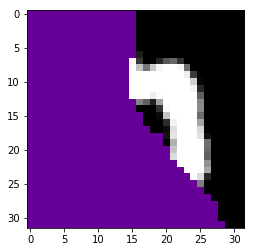

In [102]:
# x_col[0].shape
%matplotlib inline
plt.imshow(x_col[3])
plt.show()

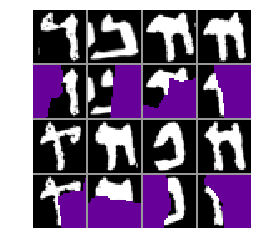

In [130]:
inds = np.random.permutation(len(x_col))[:8]
# x =sdfs
# xcv= x_col[inds]
# data=255-data
x=np.zeros((16,32,32,3),dtype=np.uint8)
x[:4]=data[inds[:4]]
x[4:8]=x_col[inds[:4]]
x[8:12]=data[inds[4:]]
x[12:]=x_col[inds[4:]]
plt.imshow(img_tile(x,aspect_ratio=4/4,border_color=153))
plt.axis('off')
plt.show()


In [121]:
x1=x

In [126]:
x2=x

In [131]:
x3=x

In [134]:
for i,x in enumerate([img_tile(x1,aspect_ratio=4/4,border_color=153),img_tile(x2,aspect_ratio=4/4,border_color=153),img_tile(x3,aspect_ratio=4/4,border_color=153)]):
    print(x.shape)
    plt.imsave('/home/lioruzan/samples%d.png'%i,x)

(131, 131, 3)
(131, 131, 3)
(131, 131, 3)


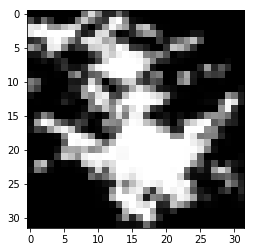

In [152]:
from glob import glob
import scipy.misc as sm

l  = glob('/home/lioruzan/figures/cand*.*')
imgs = [plt.imread(o)[:,:,np.newaxis].repeat(3,2) for o in l]
imgs = [sm.imresize(o,(32,32),interp='bicubic') for o in imgs]
plt.imshow(imgs[4]);plt.show()

In [161]:
im=img_tile(imgs[2:],aspect_ratio=2/3,border_color=153)

In [163]:
plt.imsave('/home/lioruzan/figures/bad_samples.png',im)


### ABCDAEF

In [2]:
from glob import glob
import os
import scipy.misc as sm
import numpy as np

root = '/home/lioruzan/Desktop/pixelcnn_examples/generated_test_samples/'
g = [sm.imread(o) for o in sorted(glob(os.path.join(root,'*_g.png')))]
s = [sm.imread(o) for o in sorted(glob(os.path.join(root,'*_s.png')))]
x = [sm.imread(o) for o in sorted(glob(os.path.join(root,'*_x.png')))]

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
l = []
for i in range(19):
    l += x[i*20:(i+1)*20]
    l += g[i*20:(i+1)*20]
    l += s[i*20:(i+1)*20]

In [6]:
o=img_tile(l,aspect_ratio=(57/20))

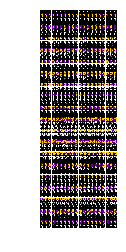

In [10]:
plt.imshow(o)
plt.axis('off')
plt.imsave(os.path.join(root,'..','generated_test_samples.png'),o)

(1880, 659, 4)